# Implementación del esquema de BOF-BoVW para el reconocimiento de escenas

## Análisis de datos exploratorio

In [1]:
!pwd

/home/mario/Documents/Proyecto_AYUDAME_Testing/BoVW


In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
import scipy.cluster.vq as vq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [3]:
class_names = np.load("Datasets/class_names_02.npy")
pcd_names = np.load("Datasets/pcd_names_02.npy")
targets = np.load("Datasets/targets_02.npy")
filehandler = open("Datasets/bofs_02.bin", 'rb')
bofs = pickle.load(filehandler)
filehandler.close()

In [4]:
class_names

array(['chess', 'fire', 'heads', 'office', 'pumpkin', 'redkitchen',
       'stairs'], dtype='<U10')

In [5]:
print(pcd_names[:3])
print(pcd_names.shape)

['frame-000000' 'frame-000001' 'frame-000002']
(6494,)


In [6]:
print(targets[:3])
print(targets.shape)

[0 0 0]
(6494,)


In [7]:
print(len(bofs))
for bof in bofs[:3]:
    print(bof.shape)

6494
(2, 180)
(2, 180)
(2, 180)


In [8]:
bofs_np = np.vstack(bofs)
bofs_np.shape

(28485, 180)

In [9]:
classes,count_classes = np.unique(targets, return_counts=True)
class_dict = dict(zip(classes.astype('int'),count_classes))
print(class_dict)

{0: 1000, 1: 1000, 2: 994, 3: 1000, 4: 1000, 5: 1000, 6: 500}


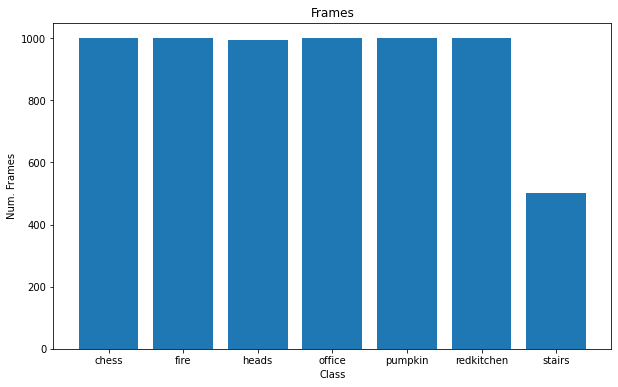

In [11]:
plt.figure(figsize=(10, 6))
plt.bar(classes, count_classes,tick_label=class_names)
plt.title('Frames')
plt.ylabel('Num. Frames')
plt.xlabel('Class')
plt.show()

### División de datos

In [12]:
X_train, X_test, y_train, y_test = train_test_split(bofs, targets,
    shuffle = True, random_state = 8)

In [13]:
print(len(X_train))

4870


## BoVW

In [14]:
def getCodebook(descriptors_list,k,seed):
    descriptors = np.vstack(descriptors_list)
    num_samples = descriptors.shape[0]
    print("Computing kmeans on "+str(num_samples)+" samples with "+str(k)+" centroids")
    init = time.time()
    codebook = vq.kmeans(obs=descriptors,k_or_guess=k,iter=10,seed=seed)[0]
    end = time.time()
    print("Done in "+str(end-init)+" secs.")
    return codebook
																					
def getBoVWRepresentation(descriptors,k,codebook):
    print("Extracting visual word representations")
    init = time.time()
    num_imgs = len(descriptors)
    visual_words = np.zeros((num_imgs,k),dtype=np.float32)
    for i in range(num_imgs):
        words = vq.vq(descriptors[i],codebook)[0]
        visual_words[i,:] = np.bincount(words,minlength=k)
    end=time.time()
    print("Done in "+str(end-init)+" secs.")
    return visual_words

In [16]:
k = 256
codebook = getCodebook(X_train,k,13)

Computing kmeans on 21359 samples with 256 centroids
Done in 111.61352181434631 secs.


In [17]:
bofs_quantized,bofs_q_dis = vq.vq(np.vstack(X_train),codebook)

In [19]:
np.mean(bofs_q_dis)

1.4079923409689854

A continuación se revisa la distribución del vocabulario visual con respecto a las BOF, es decir,
por cada palabra en el vocabulario, cuantas BOF asignadas tiene.

In [20]:
code,count_code = np.unique(bofs_quantized, return_counts=True)
code_dic = dict(zip(code,count_code))
# print(code_dic)

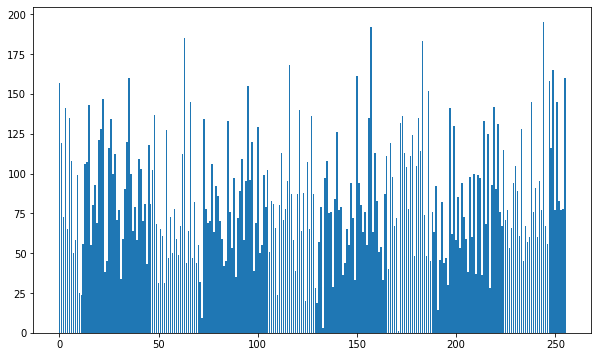

In [21]:
plt.figure(figsize=(10, 6))
plt.bar(code, count_code)
plt.show()

### Obtención de la representación BoVW

In [22]:
vw_train = getBoVWRepresentation(X_train,k,codebook)
vw_train.shape

Extracting visual word representations
Done in 3.323446750640869 secs.


(4870, 256)

In [23]:
vw_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0.

In [24]:
vw_test = getBoVWRepresentation(X_test,k,codebook)
vw_test.shape

Extracting visual word representations
Done in 1.1916024684906006 secs.


(1624, 256)

## Preprocesamiento de datos
### Estandarización de datos

In [25]:
stdSlr = StandardScaler()
train = vw_train
train = stdSlr.fit_transform(train)
train[0]

array([-0.16410702, -0.15691769, -0.12336063, -0.14472017, -0.1163081 ,
       -0.11534987, -0.1491912 , -0.08853788, -0.10978706, -0.14404988,
       -0.07183285, -0.07037427, -0.10595804, -0.14916505, -0.14319703,
       -0.14757639, -0.10315029, -0.12923414, -0.13515486, -0.1198833 ,
       -0.15698288, -0.16429496, -0.17519614, -0.08868054, -0.09657342,
       -0.15484515, -0.16327095, -0.14333475, -0.15342523, -0.12163367,
       -0.12674814, -0.08384869, -0.11074097, -0.13005291, -0.15760304,
       -0.16688593, -0.13792118, -0.11539796, -0.12372342, -0.10978706,
       -0.14467269, -0.1469928 , -0.11145706, -0.12845029, -0.09438339,
       -0.15758061, -0.1254151 , -0.1407337 , -0.1618385 , -0.11400734,
       -0.08003926, -0.1163081 , -0.11080127, -0.08003926, -0.16363466,
       -0.09871662, -0.12006628, -0.1018501 , -0.12758185, -0.11074097,
       -0.100816  , -0.11636066, -0.15069562, -0.16700554, -0.07905898,
       -0.10871784, -0.1715592 , -0.09871662, -0.13086691, -0.09

In [26]:
test = vw_test
test = stdSlr.transform(test)

### Análisis de componentes principales

In [42]:
pca = PCA()
pca.fit(train)
pca.explained_variance_ratio_

array([0.01595764, 0.01271896, 0.01231668, 0.01208354, 0.01119396,
       0.01073583, 0.01031986, 0.01022761, 0.01012168, 0.00969572,
       0.00954958, 0.00921163, 0.00898627, 0.00885287, 0.00872653,
       0.00853367, 0.00824769, 0.00802489, 0.00790226, 0.00781044,
       0.00762845, 0.00755407, 0.00749582, 0.00743713, 0.00732017,
       0.00726952, 0.00719905, 0.00715686, 0.00708885, 0.00704312,
       0.00698117, 0.00689769, 0.00683015, 0.00681463, 0.00665566,
       0.00660332, 0.00651685, 0.00645714, 0.00638369, 0.0063318 ,
       0.00629803, 0.00626778, 0.00622336, 0.00618919, 0.00615086,
       0.0061149 , 0.00603805, 0.00602054, 0.00595657, 0.00589405,
       0.00584516, 0.00579931, 0.00579131, 0.00573451, 0.00570978,
       0.00566268, 0.00560241, 0.00556357, 0.00553517, 0.00547057,
       0.0054405 , 0.00541411, 0.00538286, 0.00531439, 0.00527839,
       0.00522586, 0.00517931, 0.00515571, 0.00512678, 0.00508629,
       0.0050748 , 0.00503695, 0.00502622, 0.00500315, 0.00494

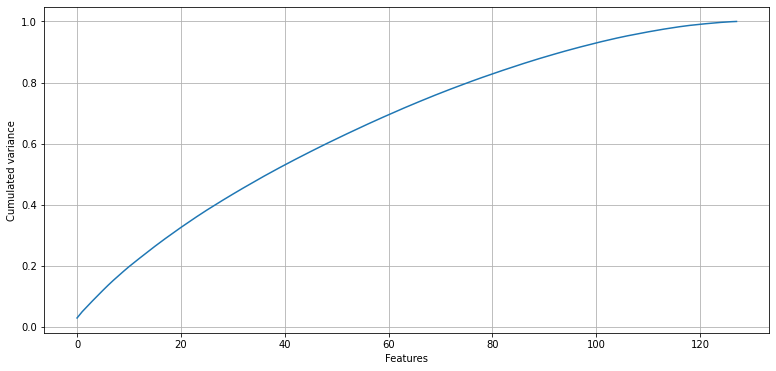

In [24]:
cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(13,6))
plt.plot(cum_var)
plt.xlabel('Features')
plt.ylabel('Cumulated variance')
plt.grid()
plt.show()

In [25]:
cum_var[89]

0.8783105

In [26]:
train_red = pca.transform(train)
train_red = train_red[:,:90]
train_red.shape

(1146, 90)

In [27]:
test_red = pca.transform(test)
test_red = test_red[:,:90]
test_red.shape

(382, 90)

## Clasificación

In [34]:
%%time
folds=5
start=0.01
end=10
numparams=10

tuned_parameters = [{'kernel': ['rbf'], 'C':np.linspace(start,end,num=numparams)}]
# tuned_parameters = [{'kernel': ["linear", "poly", "rbf", "sigmoid"], 'C':[1]}]
clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=folds,scoring='accuracy')
clf.fit(train, y_train)
print(clf.best_params_)

{'C': 5.5600000000000005, 'kernel': 'rbf'}
CPU times: user 6min, sys: 570 ms, total: 6min
Wall time: 6min 7s


In [36]:
%%time
classifier = svm.SVC(C=5.56,kernel='rbf').fit(train,y_train)

CPU times: user 6.79 s, sys: 101 ms, total: 6.89 s
Wall time: 7.09 s


In [37]:
100*classifier.score(train, y_train)
# 100*clf.score(train, y_train) # 91.62303665 with pca, 90 features

99.87679671457906

In [38]:
100*classifier.score(test, y_test)
# 100*clf.score(test, y_test)
# 77.48691099 with pca, 90 features, 128 words
# 79.3193 with 512 words, C=2.0768

94.70443349753694

## Validación de resultados

In [39]:
test_pred = classifier.predict(test)

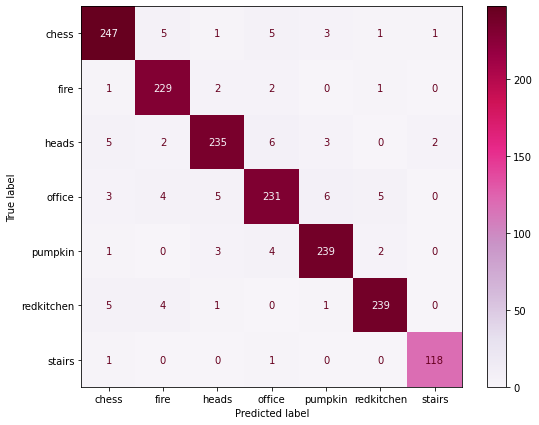

In [40]:
fig, ax = plt.subplots(figsize=(9,7))
cmd = ConfusionMatrixDisplay.from_predictions(y_true=y_test,y_pred=test_pred,
                                              ax=ax,cmap='PuRd',display_labels=class_names)
plt.show()

In [41]:
print(classification_report(y_true=y_test,y_pred=test_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       263
           1       0.94      0.97      0.96       235
           2       0.95      0.93      0.94       253
           3       0.93      0.91      0.92       254
           4       0.95      0.96      0.95       249
           5       0.96      0.96      0.96       250
           6       0.98      0.98      0.98       120

    accuracy                           0.95      1624
   macro avg       0.95      0.95      0.95      1624
weighted avg       0.95      0.95      0.95      1624



## Persistencia del modelo
Para la persistencia del modelo se utiliza `joblib`, que es una implemenatción más eficiente de pickle.

In [42]:
from joblib import dump, load

Se utiliza `dump` para almacenar el modelo.

In [43]:
dump(classifier, 'model01.joblib')

['model01.joblib']

Se utiliza `load` para leerlo.

In [45]:
clf = load('model01.joblib')

In [46]:
clf.get_params()

{'C': 5.56,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}